In [37]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
import missingno as msno
import plotly.express as px
import plotting_utils
from constant import MAP_TIME_COL, NODE_TO_PARTITION_NAME
from utils import get_idle_proportion

In [38]:
"""" 
We would like to motivate the subject in terms of the impacts that it can have.
For doing so we find the the power that a node uses, while it is idle.
"""

'" \nWe would like to motivate the subject in terms of the impacts that it can have.\nFor doing so we find the the power that a node uses, while it is idle.\n'

In [39]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('/projects/2/prjs1098/system_analytics_2024/slurm_data')
folder_path_prom_data = Path('/projects/2/prjs1098/system_analytics_2024/prom_data')
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_EDA_cleaned.parquet.gzip')
df.sample(n=5)

,node,time,state,node_type,time_30min_interval,time_1hour_interval,time_2hour_interval,time_3hour_interval,time_6hour_interval,time_12hour_interval,time_day_interval
322,tcn361,2024-11-10 01:05:37,allocated,tcn,2024-11-10 01:00:00,2024-11-10 01:00:00,2024-11-10 00:00:00,2024-11-10 00:00:00,2024-11-10 00:00:00,2024-11-10 00:00:00,2024-11-10
15,tcn560,2024-11-16 14:37:01,allocated,tcn,2024-11-16 14:30:00,2024-11-16 14:00:00,2024-11-16 14:00:00,2024-11-16 12:00:00,2024-11-16 12:00:00,2024-11-16 12:00:00,2024-11-16
178,tcn1047,2024-11-22 01:41:02,idle,tcn,2024-11-22 01:30:00,2024-11-22 01:00:00,2024-11-22 00:00:00,2024-11-22 00:00:00,2024-11-22 00:00:00,2024-11-22 00:00:00,2024-11-22
230,tcn890,2024-11-12 00:17:50,allocated,tcn,2024-11-12 00:00:00,2024-11-12 00:00:00,2024-11-12 00:00:00,2024-11-12 00:00:00,2024-11-12 00:00:00,2024-11-12 00:00:00,2024-11-12
58,fcn67,2024-11-14 06:56:49,idle,fcn,2024-11-14 06:30:00,2024-11-14 06:00:00,2024-11-14 06:00:00,2024-11-14 06:00:00,2024-11-14 06:00:00,2024-11-14 00:00:00,2024-11-14


In [40]:
""" 
We need to add a column for idle power, meaning how much power a node uses in an hour when it is in idle mode?

node name      idle_power_usage
 node_1           100W
 node_2            120W 
How to get this data? since they seem to depend only on the node hardware.
Two solutions:
1) Ask experts==> No time
2) Use prom data and figure this out ==> we select this soultion.

"""
time_col = 'time_1hour_interval'
idle_duration_time = MAP_TIME_COL[time_col] * 0.98
df_stat, _, _ = get_idle_proportion(df, time_col)

# exact idle to only consider the power that was used during this duration
mask_high_idle = ((df_stat['idle_duration'] >= (idle_duration_time)) &
                                        ((df_stat['idle_proportion'] == 1)))

df_stat_1hour_idle = df_stat[mask_high_idle].copy()
display(df_stat_1hour_idle.sample(n=5))
print(f"Number of node-hour being idle: {len(df_stat_1hour_idle)}")
print(f"Number of nodes with the given condition: {df_stat_1hour_idle['node'].nunique()}")
print(df_stat_1hour_idle['node'].value_counts())
# some of the nodes only have one record, some of them  don't. 
# with getting more and more data these problems might go away because the chance is
# they become idle.

,node,time_1hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion
224730,tcn1225,2024-11-05 03:00:00,0 days 00:59:21,0 days 00:59:21,1.0
566520,tcn817,2024-11-07 01:00:00,0 days 00:59:38,0 days 00:59:38,1.0
410854,tcn485,2024-11-22 07:00:00,0 days 00:59:01,0 days 00:59:01,1.0
172966,tcn1114,2024-11-21 07:00:00,0 days 00:59:55,0 days 00:59:55,1.0
228744,tcn1233,2024-11-13 09:00:00,0 days 00:59:22,0 days 00:59:22,1.0


Number of node-hour being idle: 164972
Number of nodes with the given condition: 1476
node
fcn118     309
fcn117     309
fcn120     309
fcn111     309
fcn113     309
fcn114     309
fcn119     309
fcn112     309
fcn116     309
fcn115     309
tcn1076    308
tcn1098    308
tcn1085    308
tcn1078    308
tcn1075    308
tcn1084    308
tcn1083    308
tcn1081    308
tcn1099    308
tcn1090    308
tcn1086    308
tcn1096    308
tcn1095    308
tcn1094    308
tcn1101    308
tcn1100    308
tcn1093    308
tcn1092    308
tcn1097    308
tcn1080    308
tcn1079    308
tcn1072    308
tcn1073    308
tcn1088    308
tcn1089    308
tcn1087    308
tcn1074    308
tcn1077    308
tcn1071    308
tcn1082    308
tcn1070    308
tcn1091    308
tcn1048    307
tcn1065    307
tcn1069    307
tcn1066    307
tcn1067    307
tcn1068    307
tcn1210    307
tcn1192    307
tcn1046    307
tcn1045    307
tcn1044    307
tcn1043    307
tcn1225    307
fcn94      307
fcn93      307
tcn1035    307
tcn1034    307
tcn1033    307
tcn1032  

In [41]:
"""
Get the prom data for this rows and do average for each node.  
Do innnerjoin to not create any nan values.
Then for each node you get 1 number that says how much power is used when the node is idle for 1 hour.
we check if similar nodes actually have the same power usage when they are idle
left merge this with the df_stat that we have based on the node only."""


# prom data
df_prom_average = pd.read_parquet(folder_path_prom_data /'average_signal_prom'/'prom_average_data.parquet.gzip')
# merge the data with the df_stat
df_stat_1hour_idle = pd.merge(df_stat_1hour_idle, df_prom_average,
                   how='left', left_on=['node', 'time_1hour_interval'], 
                   right_on=['node', 'time']).copy()

display(df_stat_1hour_idle.head(), df_prom_average.head(), df_stat_1hour_idle['idle_duration'].describe())

,node,time_1hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,time,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_median,node_load5_min,node_load5_max,node_load5_mean,node_load5_median,node_memory_Active_bytes_min,node_memory_Active_bytes_max,node_memory_Active_bytes_mean,node_memory_Active_bytes_median,node_memory_Dirty_bytes_min,node_memory_Dirty_bytes_max,node_memory_Dirty_bytes_mean,node_memory_Dirty_bytes_median,node_memory_MemAvailable_bytes_min,node_memory_MemAvailable_bytes_max,node_memory_MemAvailable_bytes_mean,node_memory_MemAvailable_bytes_median,node_memory_MemFree_bytes_min,node_memory_MemFree_bytes_max,node_memory_MemFree_bytes_mean,node_memory_MemFree_bytes_median,node_memory_MemTotal_bytes_min,node_memory_MemTotal_bytes_max,node_memory_MemTotal_bytes_mean,node_memory_MemTotal_bytes_median,node_memory_Percpu_bytes_min,node_memory_Percpu_bytes_max,node_memory_Percpu_bytes_mean,node_memory_Percpu_bytes_median,node_netstat_Icmp_InErrors_min,node_netstat_Icmp_InErrors_max,node_netstat_Icmp_InErrors_mean,node_netstat_Icmp_InErrors_median,node_netstat_Icmp_InMsgs_min,node_netstat_Icmp_InMsgs_max,node_netstat_Icmp_InMsgs_mean,node_netstat_Icmp_InMsgs_median,node_netstat_Icmp_OutMsgs_min,node_netstat_Icmp_OutMsgs_max,node_netstat_Icmp_OutMsgs_mean,node_netstat_Icmp_OutMsgs_median,node_netstat_Tcp_InErrs_min

,node,time,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_median,node_load5_min,node_load5_max,node_load5_mean,node_load5_median,node_memory_Active_bytes_min,node_memory_Active_bytes_max,node_memory_Active_bytes_mean,node_memory_Active_bytes_median,node_memory_Dirty_bytes_min,node_memory_Dirty_bytes_max,node_memory_Dirty_bytes_mean,node_memory_Dirty_bytes_median,node_memory_MemAvailable_bytes_min,node_memory_MemAvailable_bytes_max,node_memory_MemAvailable_bytes_mean,node_memory_MemAvailable_bytes_median,node_memory_MemFree_bytes_min,node_memory_MemFree_bytes_max,node_memory_MemFree_bytes_mean,node_memory_MemFree_bytes_median,node_memory_MemTotal_bytes_min,node_memory_MemTotal_bytes_max,node_memory_MemTotal_bytes_mean,node_memory_MemTotal_bytes_median,node_memory_Percpu_bytes_min,node_memory_Percpu_bytes_max,node_memory_Percpu_bytes_mean,node_memory_Percpu_bytes_median,node_netstat_Icmp_InErrors_min,node_netstat_Icmp_InErrors_max,node_netstat_Icmp_InErrors_mean,node_netstat_Icmp_InErrors_median,node_netstat_Icmp_InMsgs_min,node_netstat_Icmp_InMsgs_max,node_netstat_Icmp_InMsgs_mean,node_netstat_Icmp_InMsgs_median,node_netstat_Icmp_OutMsgs_min,node_netstat_Icmp_OutMsgs_max,node_netstat_Icmp_OutMsgs_mean,node_netstat_Icmp_OutMsgs_median,node_netstat_Tcp_InErrs_min,node_netstat_Tcp_InErrs_max,node_netstat_Tcp_InErrs_mean,node_netstat_Tcp_InErrs_

count                       164972
mean     0 days 00:59:19.261426181
std      0 days 00:00:17.220296486
min                0 days 00:58:49
25%                0 days 00:59:06
50%                0 days 00:59:13
75%                0 days 00:59:38
max                0 days 00:59:57
Name: idle_duration, dtype: object

In [42]:
# good signals that we want to pick from the data set
node_time_signals = ['node', 'time', 'idle_duration','all_state_durations_in_interval',	'idle_proportion'] 
surf_power_signals = ['surf_cpu_power_mean', 'surf_sys_power_mean', 'surf_gpu_board_power_mean', 
                      'surf_mem_power_mean']

# make sure that no power is nan, we remove them, by getting more data from prom,
# the number of these row decreases
mask = df_stat_1hour_idle['surf_sys_power_mean'].isna()
df_idle_1hour_power_signals = (df_stat_1hour_idle[~mask])[node_time_signals + surf_power_signals].copy()


# get the average power for each node
df_idle_power_average = df_idle_1hour_power_signals.groupby('node', as_index=False)[['surf_cpu_power_mean','surf_sys_power_mean', 
                                               'surf_gpu_board_power_mean']].mean(numeric_only=True)
display(df_idle_1hour_power_signals.head(), df_idle_power_average.head(), 
                    df_idle_power_average.describe())

,node,time,idle_duration,all_state_durations_in_interval,idle_proportion,surf_cpu_power_mean,surf_sys_power_mean,surf_gpu_board_power_mean,surf_mem_power_mean
0,fcn1,2024-11-09 09:00:00,0 days 00:59:15,0 days 00:59:15,1.0,176.2333,346.0833,NaN,NaN
1,fcn1,2024-11-09 10:00:00,0 days 00:59:31,0 days 00:59:31,1.0,177.5250,345.0000,NaN,NaN
2,fcn1,2024-11-09 11:00:00,0 days 00:59:44,0 days 00:59:44,1.0,176.8000,345.2500,NaN,NaN
3,fcn1,2024-11-09 12:00:00,0 days 00:59:20,0 days 00:59:20,1.0,176.2417,345.5000,NaN,NaN
4,fcn1,2024-11-09 13:00:00,0 days 00:59:45,0 days 00:59:45,1.0,177.0667,345.2500,NaN,NaN


,node,surf_cpu_power_mean,surf_sys_power_mean,surf_gpu_board_power_mean
0,fcn1,177.3173,346.1029,NaN
1,fcn10,176.0553,333.4799,NaN
2,fcn100,57.8500,227.7546,NaN
3,fcn101,57.8245,195.5255,NaN
4,fcn102,58.5736,239.7111,NaN


,surf_cpu_power_mean,surf_sys_power_mean,surf_gpu_board_power_mean
count,1227.0000,1227.0000,115.0000
mean,116.1847,284.6420,336.2583
std,65.2459,141.8586,121.6012
min,40.0000,159.4635,179.6983
25%,60.5642,199.3026,227.8533
50%,70.5238,229.0370,305.3125
75%,175.1292,299.8824,420.0000
max,349.3750,1230.8333,879.0833


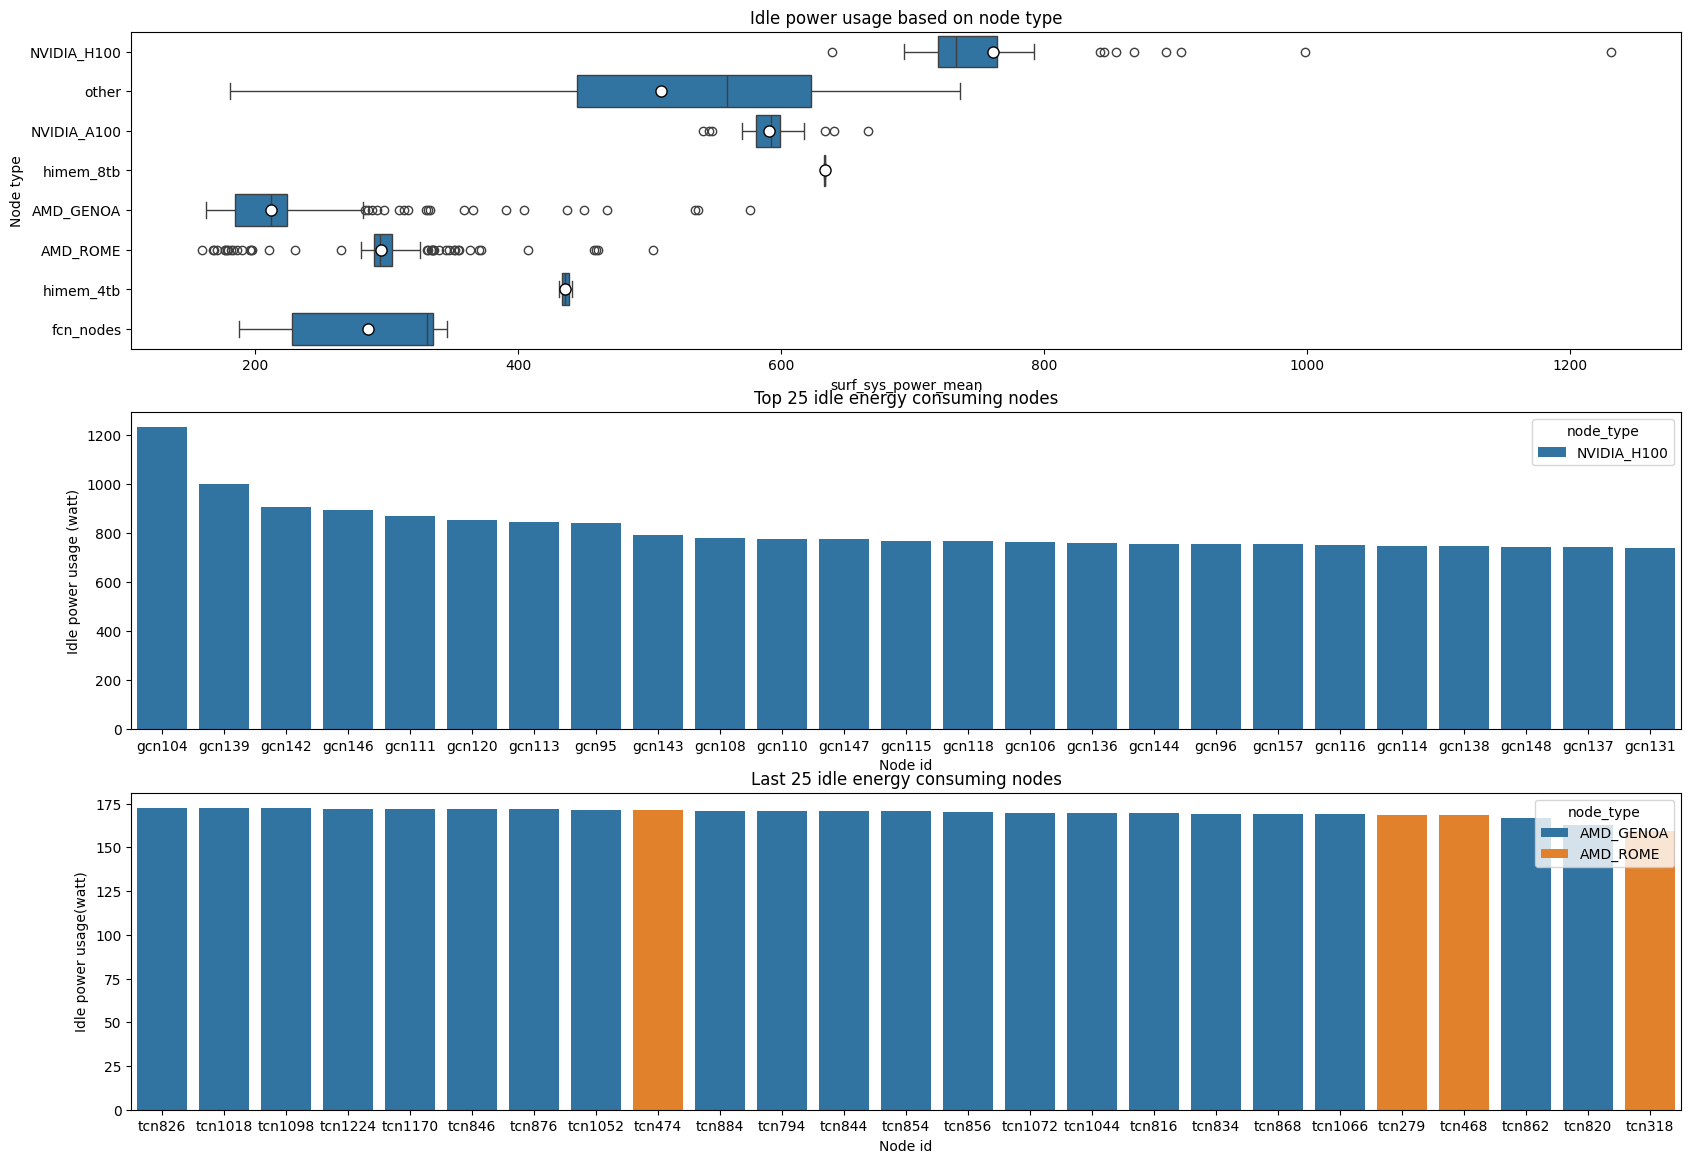

In [43]:
"""  
We show the distribution for idle power usage.
What are the nodes that consume more energy if they are idle? 
What are the idle power usage per partitions.
"""

df_temp = df_idle_power_average.copy()
df_temp.sort_values(['surf_sys_power_mean'], inplace=True, ascending=False)

df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 14))

sns.boxplot(df_temp, x='surf_sys_power_mean', y='node_type', showmeans=True, ax=ax[0],
            meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
# sns.ecdfplot(df_temp, x='Number_of_jobs', hue='node_type', ax=ax[1])



sns.barplot(df_temp.iloc[0:25], x='node', y='surf_sys_power_mean', hue='node_type', ax=ax[1])
sns.barplot(df_temp.iloc[-25:], x='node', y='surf_sys_power_mean', hue='node_type', ax=ax[2])


ax[0].set_ylabel("Node type")
ax[0].set_title("Idle power usage based on node type")

ax[1].set_title("Top 25 idle energy consuming nodes")
ax[1].set_ylabel("Idle power usage (watt)")
ax[1].set_xlabel('Node id')

ax[2].set_title("Last 25 idle energy consuming nodes")
ax[2].set_ylabel("Idle power usage(watt)")
ax[2].set_xlabel("Node id")
plt.show()




In [44]:
"""   
We measaure the idle duration for the nodes by selecting a predefined resultion.
This allows us to gracefully treat being idle for further analysis. 
The reason is we cannot use 1 hour idle and argue that the energy used in this time wasted
because a counter argunmnet might say we cannot shut down a node for 1 hour.
"""

time_col = 'time_3hour_interval'

min_idle_duration_time = MAP_TIME_COL[time_col] * 0.98
df_stat, _, _ = get_idle_proportion(df, time_col)

# exact idle to only consider the power that was used dusing this duration
mask_high_idle = ((df_stat['idle_duration'] >= (min_idle_duration_time)) &
                                        ((df_stat['idle_proportion'] == 1)))
# we only select the rows that are 100 percent idle and it took more than idle_duration_min
df_stat_highly_idle = df_stat[mask_high_idle].copy()


# turn the idle duration to hour
df_stat_highly_idle['idle_duration_hour'] = (df_stat_highly_idle['idle_duration']
                                                                                .dt.total_seconds()/3600)
display(df_stat_highly_idle.head())


,node,time_3hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,idle_duration_hour
38,fcn1,2024-11-09 09:00:00,0 days 02:59:30,0 days 02:59:30,1.0,2.9917
39,fcn1,2024-11-09 12:00:00,0 days 02:59:17,0 days 02:59:17,1.0,2.9881
40,fcn1,2024-11-09 15:00:00,0 days 02:59:42,0 days 02:59:42,1.0,2.9950
41,fcn1,2024-11-09 18:00:00,0 days 02:59:36,0 days 02:59:36,1.0,2.9933
42,fcn1,2024-11-09 21:00:00,0 days 02:59:34,0 days 02:59:34,1.0,2.9928


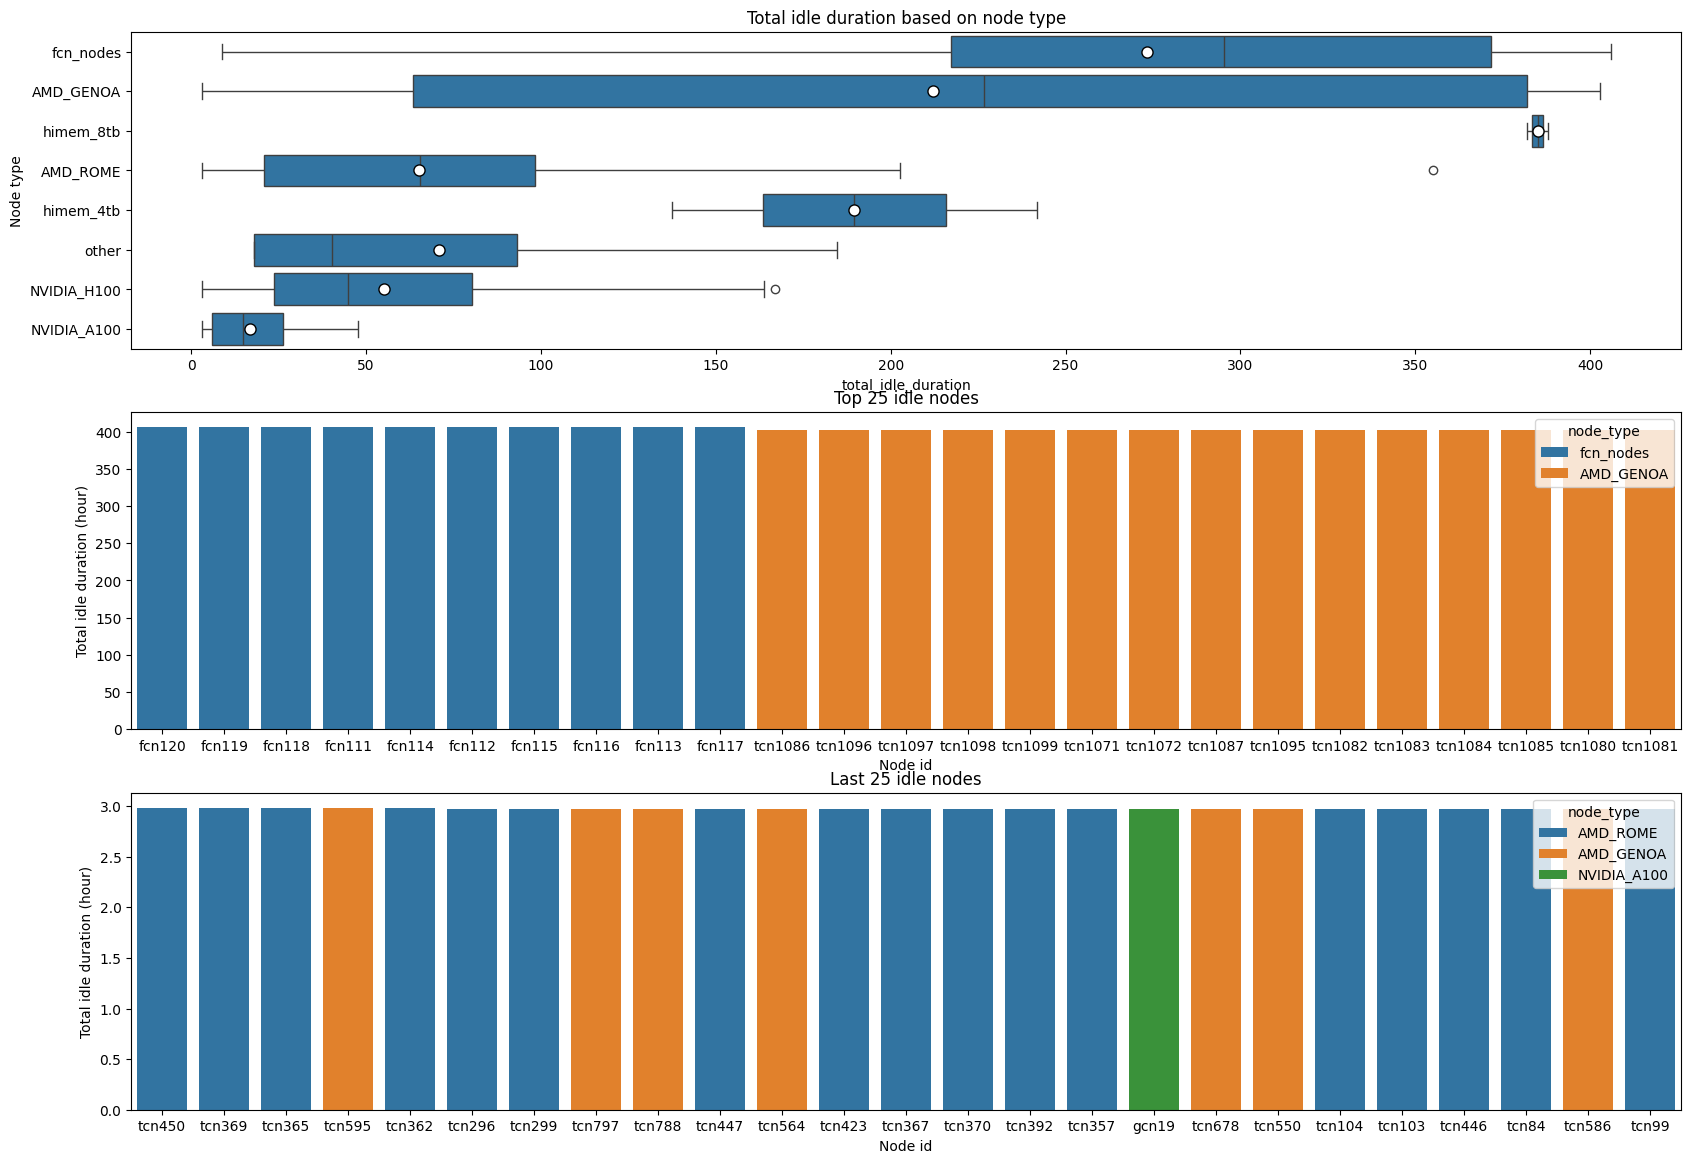

In [45]:
# plotting
df_temp = df_stat_highly_idle.groupby('node', as_index=False)['idle_duration_hour'].sum()
df_temp.rename(columns={'idle_duration_hour': 'total_idle_duration'}, inplace=True)
df_temp.sort_values(['total_idle_duration'], inplace=True, ascending=False)

df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 14))

sns.boxplot(df_temp, x='total_idle_duration', y='node_type', showmeans=True, ax=ax[0],
            meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
# sns.ecdfplot(df_temp, x='Number_of_jobs', hue='node_type', ax=ax[1])


sns.barplot(df_temp.iloc[0:25], x='node', y='total_idle_duration', hue='node_type', ax=ax[1])
sns.barplot(df_temp.iloc[-25:], x='node', y='total_idle_duration', hue='node_type', ax=ax[2])


ax[0].set_ylabel("Node type")
ax[0].set_title("Total idle duration based on node type")

ax[1].set_title("Top 25 idle nodes")
ax[1].set_ylabel("Total idle duration (hour)")
ax[1].set_xlabel('Node id')

ax[2].set_title("Last 25 idle nodes")
ax[2].set_ylabel("Total idle duration (hour)")
ax[2].set_xlabel("Node id")
plt.show()





In [46]:
"""  
We compute energy consumption for the idle nodes, for doing so we use the data farme
that shows the amount of power useage for each idle node.
"""
KILO_WAT_CONVERSION = 1000

# do the left join with df_idle_power_average
df_high_idle_with_average_power = pd.merge(left=df_stat_highly_idle, right=df_idle_power_average, 
              how='left', on='node')

# use surf sys power and compute the idle kilo wat hour
df_high_idle_with_average_power['idle_kilo_watt_hour'] = (df_high_idle_with_average_power['idle_duration_hour']
                                                         .multiply(df_high_idle_with_average_power['surf_sys_power_mean']
                                                                   /KILO_WAT_CONVERSION, fill_value=0))
display(df_stat_highly_idle. head(), df_high_idle_with_average_power.head())

,node,time_3hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,idle_duration_hour
38,fcn1,2024-11-09 09:00:00,0 days 02:59:30,0 days 02:59:30,1.0,2.9917
39,fcn1,2024-11-09 12:00:00,0 days 02:59:17,0 days 02:59:17,1.0,2.9881
40,fcn1,2024-11-09 15:00:00,0 days 02:59:42,0 days 02:59:42,1.0,2.9950
41,fcn1,2024-11-09 18:00:00,0 days 02:59:36,0 days 02:59:36,1.0,2.9933
42,fcn1,2024-11-09 21:00:00,0 days 02:59:34,0 days 02:59:34,1.0,2.9928


,node,time_3hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,idle_duration_hour,surf_cpu_power_mean,surf_sys_power_mean,surf_gpu_board_power_mean,idle_kilo_watt_hour
0,fcn1,2024-11-09 09:00:00,0 days 02:59:30,0 days 02:59:30,1.0,2.9917,177.3173,346.1029,NaN,1.0354
1,fcn1,2024-11-09 12:00:00,0 days 02:59:17,0 days 02:59:17,1.0,2.9881,177.3173,346.1029,NaN,1.0342
2,fcn1,2024-11-09 15:00:00,0 days 02:59:42,0 days 02:59:42,1.0,2.9950,177.3173,346.1029,NaN,1.0366
3,fcn1,2024-11-09 18:00:00,0 days 02:59:36,0 days 02:59:36,1.0,2.9933,177.3173,346.1029,NaN,1.0360
4,fcn1,2024-11-09 21:00:00,0 days 02:59:34,0 days 02:59:34,1.0,2.9928,177.3173,346.1029,NaN,1.0358


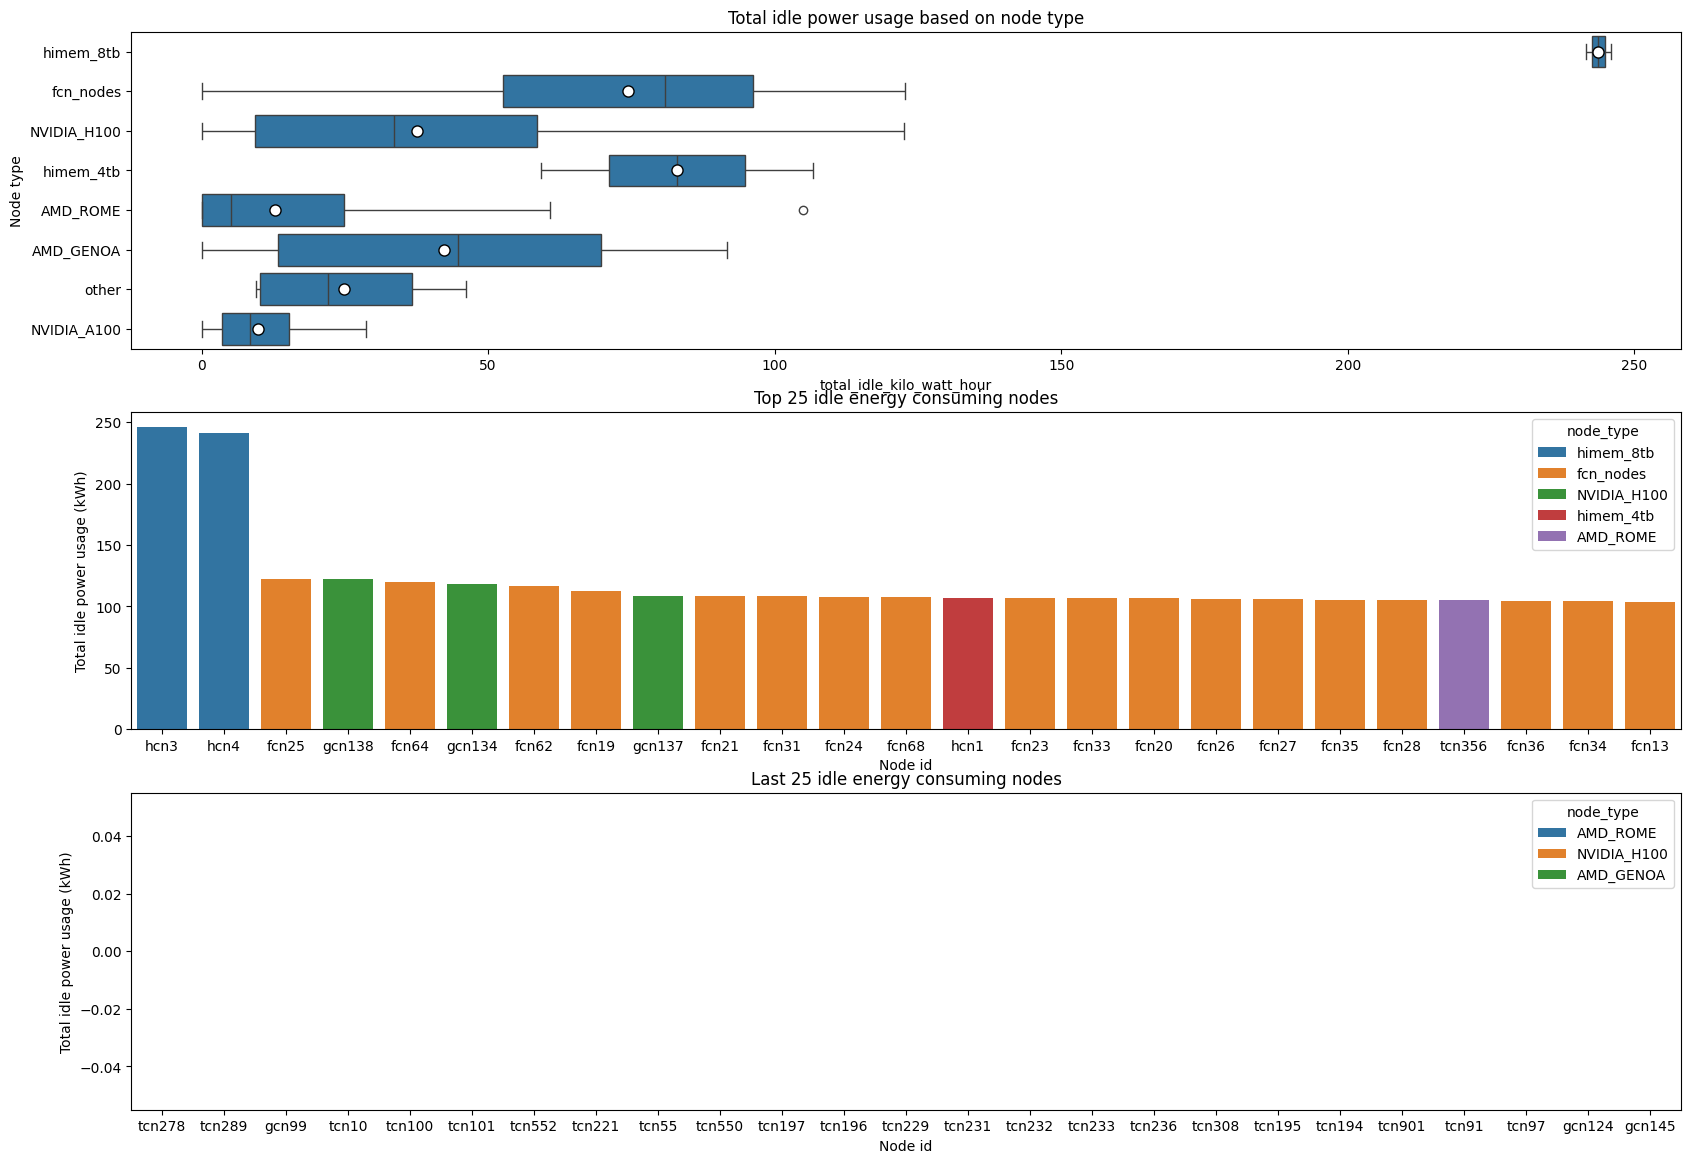

In [47]:
# plotting

df_temp = df_high_idle_with_average_power.groupby('node', as_index=False)['idle_kilo_watt_hour'].sum()
df_temp.rename(columns={'idle_kilo_watt_hour': 'total_idle_kilo_watt_hour'}, inplace=True)
df_temp.sort_values(['total_idle_kilo_watt_hour'], inplace=True, ascending=False)

df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 14))

sns.boxplot(df_temp, x='total_idle_kilo_watt_hour', y='node_type', showmeans=True, ax=ax[0],
            meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
# sns.ecdfplot(df_temp, x='Number_of_jobs', hue='node_type', ax=ax[1])


sns.barplot(df_temp.iloc[0:25], x='node', y='total_idle_kilo_watt_hour', hue='node_type', ax=ax[1])
sns.barplot(df_temp.iloc[-25:], x='node', y='total_idle_kilo_watt_hour', hue='node_type', ax=ax[2])


ax[0].set_ylabel("Node type")
ax[0].set_title("Total idle power usage based on node type")

ax[1].set_title("Top 25 idle energy consuming nodes")
ax[1].set_ylabel("Total idle power usage (kWh)")
ax[1].set_xlabel('Node id')

ax[2].set_title("Last 25 idle energy consuming nodes")
ax[2].set_ylabel("Total idle power usage (kWh)")
ax[2].set_xlabel("Node id")
plt.show()




In [48]:
"""  
What is the source of the electricity price?
We get the price for electricity for the following website. They report the data from
CBS which is the central organziation for statistic in the Netherlands.
We guess that the price can be lower for major consumers.
For this reason we also divide the price by 3. 
"""
from IPython.display import HTML

# Embed iframe with custom styling
HTML("""
<iframe title="Grafiek gemiddelde stroomprijs per kWh t/m sept 2024"
        aria-label="Interactive line chart"
        id="datawrapper-chart-b9Uc0"
        src="https://datawrapper.dwcdn.net/b9Uc0/21/"
        scrolling="no"
        frameborder="0"
        style="width: 100%; min-width: 100% !important; border: none; background-color: #f4f4f9;"
        height="662"
        data-external="1"></iframe>
""")


In [73]:
# price for electricity per kilo wat hour
ELEC_PRICE_KWH = 0.30
# CO2 emmission kg per kWh, we use the data from
# reference: https://www.cbs.nl/nl-nl/achtergrond/2023/51/rendementen-en-co2-emissie-van-elektriciteitsproductie-in-nederland-update-2022
CO2_EMISSION = 0.27


# compute the price for the kilo-wat hour
df_high_idle_with_average_power['financial_cost'] = (df_high_idle_with_average_power['idle_kilo_watt_hour'] 
                                                                                         * ELEC_PRICE_KWH)
df_high_idle_with_average_power['co2_emission'] = (df_high_idle_with_average_power['idle_kilo_watt_hour'] 
                                                                                         * CO2_EMISSION)
total_financial_cost = df_high_idle_with_average_power['financial_cost'].sum()
total_co2_emission = df_high_idle_with_average_power['co2_emission'].sum()
total_year_idle = (df_high_idle_with_average_power['idle_duration_hour'].sum())/ (24 * 365)
total_power_idle = (df_high_idle_with_average_power['surf_sys_power_mean'].sum())/KILO_WAT_CONVERSION

print(f"Total financial cost occured due to idle nodes: {total_financial_cost} Euro")
print(f"Total amount of CO2 emission occured due to idle nodes: {total_co2_emission} kg CO2")


Total financial cost occured due to idle nodes: 14602.274547787882 Euro
Total amount of CO2 emission occured due to idle nodes: 13142.047093009094 kg CO2


In [74]:
df_temp = df_high_idle_with_average_power[['node', 'idle_duration_hour','surf_sys_power_mean',
                                           'financial_cost', 'co2_emission']].copy()
# df_temp['normalized_financial_cost'] = df_temp['financial_cost']/total_financial_cost
# df_temp['normalized_co2_emission'] = df_temp['co2_emission']/total_co2_emission
df_temp['node_type'] = df_temp['node'].apply(lambda x: NODE_TO_PARTITION_NAME.get(x, 'other'))
# df_stat_fin_co2_cost = df_temp.groupby('node_type', as_index=False)[['normalized_financial_cost', 
#                                                                      'normalized_co2_emission']].sum()


df_stat_fin_co2_cost = df_temp.groupby('node_type', as_index=False)[['idle_duration_hour', 'surf_sys_power_mean',
                                                                     'financial_cost','co2_emission']].sum()
df_stat_fin_co2_cost

,node_type,idle_duration_hour,surf_sys_power_mean,financial_cost,co2_emission
0,AMD_GENOA,148795.4256,9.9621e+06,8917.5377,8025.7839
1,AMD_ROME,32369.3836,2.1232e+06,1896.0783,1706.4704
2,NVIDIA_A100,838.9025,1.6467e+05,147.4817,132.7336
3,NVIDIA_H100,3590.1675,8.2116e+05,733.9646,660.5682
4,fcn_nodes,32803.9206,2.9949e+06,2681.2995,2413.1695
5,himem_4tb,379.2972,5.5554e+04,49.7756,44.7980
6,himem_8tb,769.9881,1.6335e+05,146.2488,131.6239
7,other,283.1022,3.3409e+04,29.8884,26.8996


In [77]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=2, cols=2,
                    specs=[[{'type': 'domain'}, {'type': 'domain'}],[{'type': 'domain'}, {'type': 'domain'}]], 
                    subplot_titles=[f'Total idle time: {total_year_idle:9.2f} years',
                                    f'Total idle power usage: {total_power_idle:9.2f} Kw',
                                    f'Total financial cost: {total_financial_cost:9.2f} Euro',
                                    f'Total amount of CO2 emission: {total_co2_emission:9.2f} Kg'])


# Add Pie charts
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["idle_duration_hour"],
        name="idle duration",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name

    ),
    1, 1
)
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["surf_sys_power_mean"],
        name="idle power usage",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name
    ),
    1, 2
)



# Add Pie charts
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["financial_cost"],
        name="Financial Cost",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name

    ),
    2, 2
)
fig.add_trace(
    go.Pie(
        labels=df_stat_fin_co2_cost["node_type"],
        values=df_stat_fin_co2_cost["co2_emission"],
        name="CO2 Emission",
        #textinfo="value",
        hoverinfo="label+value+name"  # Show label, value, and name
    ),
    2, 1
)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="name+percent+label")

# Add annotations
# fig.update_layout(
#     title_text="Financial Cost and CO2 Emissions due to idle nodes",
#     annotations=[
#         dict(text='Cost(Euro)', x=0.18, y=0.5, font_size=20, showarrow=False),
#         dict(text='CO2(Kg)', x=0.81, y=0.5, font_size=20, showarrow=False)
#     ]
# )
fig.show()

In [52]:
# We also need to get the power usage for those nodes that have nor appeared in prom yet.